<a href="https://colab.research.google.com/github/giuliaries/object-detection/blob/main/vit_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer Object Detection with YOLOS

YOLOS Object Detection Training with Roboflow Dataset


In [ ]:
# ============================================================
# CHECK GPU
# ============================================================

import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU found - training will be VERY slow with ViT!")


GPU available: True
GPU: Tesla T4
VRAM: 15.64 GB


In [ ]:
# ============================================================
# INSTALL DEPENDENCIES
# ============================================================

%%capture
!pip install -q transformers torch torchvision roboflow pillow matplotlib numpy pyyaml datasets accelerate timm
!pip install -q torchmetrics seaborn   # for mAP and confusion matrix

print("✅ All dependencies installed!")


In [ ]:
# ============================================================
# CONFIGURATION
# ============================================================

ROBOFLOW_API_KEY   = "Tci79vVpwGbCxMmTBrDt"
ROBOFLOW_WORKSPACE = "university-h35bh"
ROBOFLOW_PROJECT   = "cat-npklm-7ijlg"
ROBOFLOW_VERSION   = 1

MODEL_NAME  = "hustvl/yolos-small"   # Pure ViT-S/16, 30.7M params
OUTPUT_DIR  = "./yolos_finetuned"

# Training parameters
NUM_EPOCHS    = 15    # intentionally limited: ViT on small datasets overfits quickly
BATCH_SIZE    = 8
LEARNING_RATE = 5e-5
EVAL_STEPS    = 100   # evaluate every 100 steps
PATIENCE      = 3     # early stopping: stop after 3 evals with no improvement

# Inference parameters
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD        = 0.5   # standard NMS threshold

TEST_IMAGES_DIR = "./test_images"

print("✅ Configuration loaded")
print(f"   Model:      {MODEL_NAME}")
print(f"   Epochs:     max {NUM_EPOCHS}, early stopping patience={PATIENCE} evals")
print(f"   NMS IoU:    {IOU_THRESHOLD}")
print(f"   Confidence: {CONFIDENCE_THRESHOLD}")


✅ Configuration loaded
   Model:      hustvl/yolos-small
   Epochs:     max 15, early stopping patience=3 evals
   NMS IoU:    0.5
   Confidence: 0.3


In [ ]:
# ============================================================
# IMPORTS
# ============================================================

import os
import json
import shutil
import zipfile
import math
import textwrap
import torch
import yaml
import numpy as np
import seaborn as sns
from PIL import Image
from pathlib import Path
from roboflow import Roboflow
from transformers import (
    YolosImageProcessor,
    YolosForObjectDetection,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset
import torchvision
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports completed")
print("\n🔷 Using YOLOS - Pure Vision Transformer Architecture")


✅ Imports completed

🔷 Using YOLOS - Pure Vision Transformer Architecture


In [ ]:
# ============================================================
# CUSTOM DATASET FOR YOLOS
# ============================================================

class RoboflowYOLOSDataset(Dataset):
    """Custom dataset for YOLOS object detection"""

    def __init__(self, data_dir, processor, split='train'):
        self.data_dir  = Path(data_dir)
        self.processor = processor
        self.split     = split

        self.images_dir = self.data_dir / split / 'images'
        self.labels_dir = self.data_dir / split / 'labels'

        self.classes  = self._load_classes()
        self.id2label = {i: label for i, label in enumerate(self.classes)}
        self.label2id = {label: i for i, label in enumerate(self.classes)}

        self.image_files = sorted(
            list(self.images_dir.glob('*.jpg')) +
            list(self.images_dir.glob('*.png'))
        )
        print(f"✅ Dataset loaded: {len(self.image_files)} images in '{split}' set")
        print(f"📋 Classes: {self.classes}")

    def _load_classes(self):
        yaml_path = self.data_dir / 'data.yaml'
        if yaml_path.exists():
            with open(yaml_path, 'r') as f:
                return yaml.safe_load(f)['names']
        return []

    def _load_yolo_annotations(self, label_path, img_width, img_height):
        boxes, labels = [], []
        if not label_path.exists():
            return boxes, labels
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width    = float(parts[3]) * img_width
                height   = float(parts[4]) * img_height
                boxes.append([x_center - width/2, y_center - height/2, width, height])
                labels.append(class_id)
        return boxes, labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image    = Image.open(img_path).convert("RGB")
        img_w, img_h = image.size

        label_path = self.labels_dir / f"{img_path.stem}.txt"
        boxes, labels = self._load_yolo_annotations(label_path, img_w, img_h)

        target = {
            "image_id": torch.tensor([idx]),
            "annotations": [
                {"bbox": box, "category_id": label,
                 "area": box[2] * box[3], "iscrowd": 0}
                for box, label in zip(boxes, labels)
            ]
        }

        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "labels": encoding["labels"][0]
        }

print("✅ Dataset class defined")


✅ Dataset class defined


In [ ]:
# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def download_roboflow_dataset(api_key, workspace, project, version):
    """Download dataset from Roboflow"""
    print("📥 Downloading dataset from Roboflow...")
    try:
        rf      = Roboflow(api_key=api_key)
        project = rf.workspace(workspace).project(project)
        dataset = project.version(version).download("yolov8")
        print(f"✅ Dataset downloaded to: {dataset.location}")
        return dataset.location
    except Exception as e:
        print(f"❌ Error during download: {e}")
        return None


def apply_nms(boxes, scores, labels, iou_threshold=0.5):
    """Apply Non-Maximum Suppression per class"""
    if len(boxes) == 0:
        return boxes, scores, labels
    keep_indices = []
    for label in torch.unique(labels):
        mask    = labels == label
        indices = torch.where(mask)[0]
        keep    = torchvision.ops.nms(boxes[mask], scores[mask], iou_threshold)
        keep_indices.extend(indices[keep].tolist())
    keep_indices = sorted(keep_indices)
    return boxes[keep_indices], scores[keep_indices], labels[keep_indices]


def predict_image(image_pil, model, processor, device,
                  conf_threshold=0.0, iou_threshold=IOU_THRESHOLD):
    """Run inference + NMS on a PIL image. Returns cpu tensors."""
    inputs = processor(images=image_pil, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    target_sizes = torch.tensor([image_pil.size[::-1]]).to(device)
    res = processor.post_process_object_detection(
        outputs, threshold=conf_threshold, target_sizes=target_sizes)[0]
    if len(res["scores"]) > 0:
        b, s, l = apply_nms(res["boxes"], res["scores"], res["labels"],
                            iou_threshold=iou_threshold)
        return {"boxes": b.cpu(), "scores": s.cpu(), "labels": l.cpu()}
    return {"boxes": res["boxes"].cpu(), "scores": res["scores"].cpu(),
            "labels": res["labels"].cpu()}


def visualize_predictions(image, predictions, processor, threshold=0.3):
    """Draw bounding boxes on a PIL image. Returns matplotlib figure."""
    img_array = np.array(image) if isinstance(image, Image.Image) else image
    fig, ax   = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_array)

    scores = predictions["scores"]
    labels = predictions["labels"]
    boxes  = predictions["boxes"]
    keep   = scores > threshold

    print(f"   📊 Showing {keep.sum().item()} detections above threshold {threshold}")

    colors = plt.cm.hsv(np.linspace(0, 1, max(len(processor.id2label), 1)))
    for score, label, box in zip(scores[keep], labels[keep], boxes[keep]):
        x0, y0, x1, y1 = box.cpu().numpy()
        idx   = label.item()
        color = colors[idx % len(colors)]
        ax.add_patch(patches.Rectangle(
            (x0, y0), x1-x0, y1-y0,
            linewidth=2, edgecolor=color, facecolor='none'))
        name = processor.id2label.get(idx, f"Class_{idx}")
        ax.text(x0, y0 - 5, f"{name}: {score:.2f}",
                color='white', fontsize=10,
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=2))
    ax.axis('off')
    return fig


def save_model_info(model, processor, output_dir):
    info = {
        'model_type': 'YOLOS (Pure Vision Transformer)',
        'architecture': 'ViT-based (no CNN backbone)',
        'num_labels': model.config.num_labels,
        'id2label': processor.id2label,
        'label2id': processor.label2id,
        'model_name': model.config._name_or_path
    }
    with open(os.path.join(output_dir, 'model_info.json'), 'w') as f:
        json.dump(info, f, indent=2)
    print("   Model info saved")

print("✅ Utility functions defined")


✅ Utility functions defined


# PART 1: TRAINING

Train the Pure Vision Transformer model.

**Note:** YOLOS may require more training time than CNN-based models!


In [ ]:
# ============================================================
# TRAINING: Download Dataset
# ============================================================

print("\n" + "="*70)
print("START TRAINING - VISION TRANSFORMER")
print("="*70 + "\n")

dataset_path = download_roboflow_dataset(
    ROBOFLOW_API_KEY, ROBOFLOW_WORKSPACE, ROBOFLOW_PROJECT, ROBOFLOW_VERSION
)
if dataset_path is None:
    raise ValueError("❌ Dataset download failed!")
print(f"\n✅ Dataset ready at: {dataset_path}")



START TRAINING - VISION TRANSFORMER

📥 Downloading dataset from Roboflow...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cat-1 in yolov8:: 100%|██████████| 631/631 [00:00<00:00, 10839.68it/s]

✅ Dataset downloaded to: /content/cat-1

✅ Dataset ready at: /content/cat-1


In [ ]:
# ============================================================
# TRAINING: Load YOLOS Model and Dataset
# ============================================================

print("\n📦 Loading YOLOS (ViT) model...")
print("\n🔷 Architecture Details:")
print("   • Model: Vision Transformer (ViT)")
print("   • Patch size: 16×16 pixels")
print("   • No CNN backbone (pure attention!)")
print("   • Direct image-to-patches processing\n")

processor = YolosImageProcessor.from_pretrained(MODEL_NAME)

print("\n📚 Preparing dataset...")
train_dataset = RoboflowYOLOSDataset(dataset_path, processor, split='train')
val_dataset   = RoboflowYOLOSDataset(dataset_path, processor, split='valid')

num_classes = len(train_dataset.classes)
id2label    = {i: label for i, label in enumerate(train_dataset.classes)}
label2id    = {label: i for i, label in id2label.items()}
processor.id2label = id2label
processor.label2id = label2id

print(f"\n🔧 Initializing YOLOS model:")
print(f"   Object classes: {num_classes} ({train_dataset.classes})")
print(f"   num_labels: {num_classes}")
print(f"   Class mapping: {id2label}")

model = YolosForObjectDetection.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

print("\n✅ Vision Transformer model ready!")
print(f"   Parameters: ~{sum(p.numel() for p in model.parameters())/1e6:.1f}M")



📦 Loading YOLOS (ViT) model...

🔷 Architecture Details:
   • Model: Vision Transformer (ViT)
   • Patch size: 16×16 pixels
   • No CNN backbone (pure attention!)
   • Direct image-to-patches processing



preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]


📚 Preparing dataset...
✅ Dataset loaded: 249 images in 'train' set
📋 Classes: ['Cats']
✅ Dataset loaded: 43 images in 'valid' set
📋 Classes: ['Cats']

🔧 Initializing YOLOS model:
   Object classes: 1 (['Cats'])
   num_labels: 1
   Class mapping: {0: 'Cats'}


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

YolosForObjectDetection LOAD REPORT from: hustvl/yolos-small
Key                                     | Status   |                                                                                      
----------------------------------------+----------+--------------------------------------------------------------------------------------
class_labels_classifier.layers.2.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([92]) vs model:torch.Size([2])          
class_labels_classifier.layers.2.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([92, 384]) vs model:torch.Size([2, 384])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.



✅ Vision Transformer model ready!
   Parameters: ~30.7M


In [ ]:
# ============================================================
# TRAINING: Train Model
# ============================================================

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([b["pixel_values"] for b in batch]),
        "labels":       [b["labels"] for b in batch],
    }

training_args = TrainingArguments(
    output_dir                  = OUTPUT_DIR,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE,
    num_train_epochs            = NUM_EPOCHS,
    learning_rate               = LEARNING_RATE,
    warmup_steps                = 100,
    weight_decay                = 0.01,
    eval_strategy               = "steps",
    save_strategy               = "steps",
    eval_steps                  = EVAL_STEPS,
    save_steps                  = EVAL_STEPS,
    save_total_limit            = 2,
    remove_unused_columns       = False,
    push_to_hub                 = False,
    logging_steps               = 50,
    load_best_model_at_end      = True,
    metric_for_best_model       = "eval_loss",
    greater_is_better           = False,
    fp16                        = torch.cuda.is_available(),
)

trainer = Trainer(
    model         = model,
    args          = training_args,
    train_dataset = train_dataset,
    eval_dataset  = val_dataset,
    data_collator = collate_fn,
    callbacks     = [EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

print(f"Starting training — max {NUM_EPOCHS} epochs, early stopping patience={PATIENCE} evals...")
print("This may take 20-40 minutes...\n")

trainer.train()

print("\n💾 Saving model...")
trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
save_model_info(model, processor, OUTPUT_DIR)

print(f"\n{'='*70}")
print("✅ TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"\nModel saved to: {OUTPUT_DIR}")


Starting training — max 15 epochs, early stopping patience=3 evals...
This may take 20-40 minutes...



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


💾 Saving model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

   Model info saved

✅ TRAINING COMPLETED!

Model saved to: ./yolos_finetuned


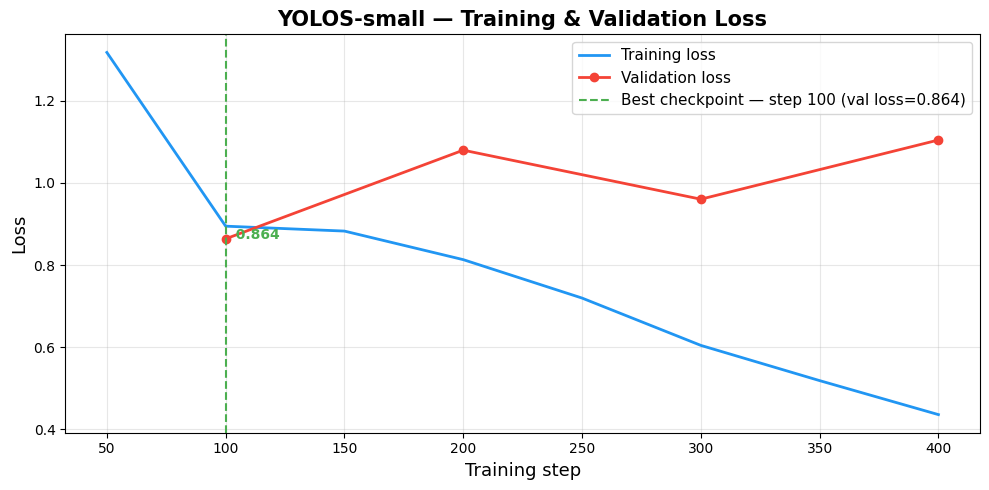


📋 Loss log:
    Step    Train loss      Val loss
  ----------------------------------
     100        0.8948        0.8639 ← best
     200        0.8132        1.0798
     300        0.6044        0.9604
     400        0.4358        1.1046


In [ ]:
# ============================================================
# TRAINING: Show Training Curves
# ============================================================

history     = trainer.state.log_history
train_steps, train_loss = [], []
eval_steps,  eval_loss  = [], []

for entry in history:
    if "loss" in entry and "eval_loss" not in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_steps, train_loss, label="Training loss",   color="#2196F3", linewidth=2)
ax.plot(eval_steps,  eval_loss,  label="Validation loss", color="#F44336",
        linewidth=2, marker="o", markersize=6)

if eval_loss:
    best_idx = int(np.argmin(eval_loss))
    ax.axvline(eval_steps[best_idx], color="#4CAF50", linestyle="--", linewidth=1.5,
               label=f"Best checkpoint — step {eval_steps[best_idx]} (val loss={eval_loss[best_idx]:.3f})")
    ax.annotate(f"  {eval_loss[best_idx]:.3f}",
                xy=(eval_steps[best_idx], eval_loss[best_idx]),
                fontsize=10, color="#4CAF50", fontweight="bold")

ax.set_xlabel("Training step", fontsize=13)
ax.set_ylabel("Loss",          fontsize=13)
ax.set_title("YOLOS-small — Training & Validation Loss", fontsize=15, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/training_curves.png", dpi=150)
plt.show()

# Print summary table
print("\n📋 Loss log:")
print(f"  {'Step':>6}  {'Train loss':>12}  {'Val loss':>12}")
print("  " + "-"*34)
eval_by_step = {e["step"]: e["eval_loss"] for e in history if "eval_loss" in e}
train_by_step = {e["step"]: e["loss"] for e in history if "loss" in e and "eval_loss" not in e}
for step, vl in sorted(eval_by_step.items()):
    # find closest train loss
    tl = min(train_by_step.items(), key=lambda x: abs(x[0]-step), default=(0, float('nan')))[1]
    marker = " ← best" if step == eval_steps[best_idx] else ""
    print(f"  {step:>6}  {tl:>12.4f}  {vl:>12.4f}{marker}")


In [ ]:
# ============================================================
# EVALUATION: mAP on Validation Set
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

metric = MeanAveragePrecision(iou_type="bbox", box_format="xyxy")

print(f"📊 Running mAP evaluation on {len(val_dataset)} validation images...")

for idx in range(len(val_dataset)):
    sample   = val_dataset[idx]
    gt_dict  = sample["labels"]
    img_h, img_w = gt_dict["orig_size"].tolist()

    # Ground truth: normalised cxcywh → absolute xyxy
    cx, cy, gw, gh = gt_dict["boxes"].unbind(-1)
    gt_boxes = torch.stack([
        (cx - gw/2) * img_w, (cy - gh/2) * img_h,
        (cx + gw/2) * img_w, (cy + gh/2) * img_h,
    ], dim=-1)

    target = [{"boxes": gt_boxes, "labels": gt_dict["class_labels"]}]

    # Prediction (all scores, NMS filters duplicates)
    image_pil = Image.open(val_dataset.image_files[idx]).convert("RGB")
    res = predict_image(image_pil, model, processor, device,
                        conf_threshold=0.0, iou_threshold=IOU_THRESHOLD)

    preds = [{"boxes": res["boxes"], "scores": res["scores"], "labels": res["labels"]}]
    metric.update(preds, target)

results_map = metric.compute()

map50   = results_map["map_50"].item()
map5095 = results_map["map"].item()
mar100  = results_map["mar_100"].item()

print("\n" + "="*70)
print("VALIDATION METRICS — YOLOS-small")
print("="*70)
print(f"  mAP@0.5        : {map50:.4f}")
print(f"  mAP@0.5:0.95   : {map5095:.4f}")
print(f"  Recall@100     : {mar100:.4f}")
print("="*70)

# Save metrics
with open(f"{OUTPUT_DIR}/eval_metrics.json", "w") as f:
    json.dump({k: v.item() if hasattr(v, "item") else str(v)
               for k, v in results_map.items()}, f, indent=2)
print(f"\n💾 Metrics saved to {OUTPUT_DIR}/eval_metrics.json")


📊 Running mAP evaluation on 43 validation images...

VALIDATION METRICS — YOLOS-small
  mAP@0.5        : 0.7766
  mAP@0.5:0.95   : 0.4408
  Recall@100     : 0.6800

💾 Metrics saved to ./yolos_finetuned/eval_metrics.json


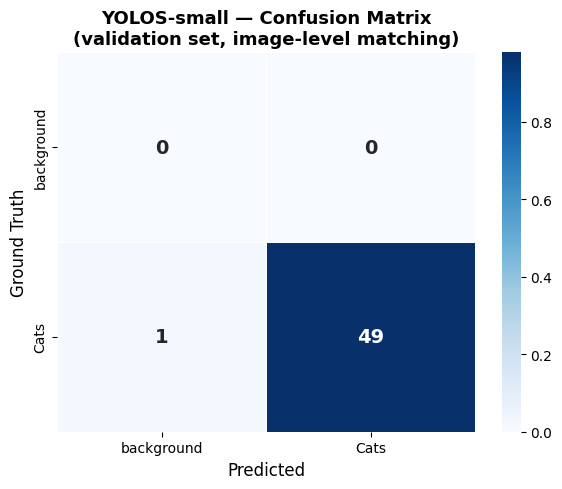


  True Positives  (cat detected correctly): 49
  False Negatives (cat missed):              1
  False Positives (background → cat):        0
  Precision: 1.000
  Recall:    0.980


In [ ]:
# ============================================================
# EVALUATION: Confusion Matrix on Validation Set
# ============================================================

# Image-level matching: for each GT object, check whether the model
# produced at least one prediction of the correct class above threshold.

y_true, y_pred = [], []

for idx in range(len(val_dataset)):
    sample    = val_dataset[idx]
    gt_cls    = sample["labels"]["class_labels"].tolist()
    image_pil = Image.open(val_dataset.image_files[idx]).convert("RGB")
    res       = predict_image(image_pil, model, processor, device,
                              conf_threshold=CONFIDENCE_THRESHOLD,
                              iou_threshold=IOU_THRESHOLD)

    pred_cls = res["labels"].tolist()

    # Each GT object: matched if a prediction of the same class exists
    for gc in gt_cls:
        y_true.append(gc)
        y_pred.append(gc if gc in pred_cls else -1)

    # Each unmatched prediction: false positive
    for pc in pred_cls:
        if pc not in gt_cls:
            y_true.append(-1)
            y_pred.append(pc)

# Build labels list: background (-1) + real classes
class_ids   = sorted(set(y_true + y_pred) - {-1})
labels_cm   = [-1] + class_ids
name_map    = {-1: "background"}
name_map.update({i: processor.id2label.get(i, f"cls{i}") for i in class_ids})
disp_names  = [name_map[l] for l in labels_cm]

cm      = sk_confusion_matrix(y_true, y_pred, labels=labels_cm)
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_norm, annot=cm, fmt="d",
            xticklabels=disp_names, yticklabels=disp_names,
            cmap="Blues", ax=ax, linewidths=0.5,
            annot_kws={"size": 14, "weight": "bold"})
ax.set_xlabel("Predicted",    fontsize=12)
ax.set_ylabel("Ground Truth", fontsize=12)
ax.set_title("YOLOS-small — Confusion Matrix\n(validation set, image-level matching)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=150)
plt.show()

# Readable summary
tp = cm[1, 1] if cm.shape[0] > 1 else 0
fn = cm[1, 0] if cm.shape[0] > 1 else 0
fp = cm[0, 1] if cm.shape[0] > 1 else 0
print(f"\n  True Positives  (cat detected correctly): {tp}")
print(f"  False Negatives (cat missed):              {fn}")
print(f"  False Positives (background → cat):        {fp}")
if tp + fp > 0:
    print(f"  Precision: {tp/(tp+fp):.3f}")
if tp + fn > 0:
    print(f"  Recall:    {tp/(tp+fn):.3f}")


# PART 2: TESTING

Test the trained Pure Vision Transformer model.


In [ ]:
# ============================================================
# TEST: Load Trained Model
# ============================================================

print("\n" + "="*70)
print("TESTING VISION TRANSFORMER")
print("="*70 + "\n")

if not os.path.exists(OUTPUT_DIR):
    raise ValueError(
        f"❌ Model not found at {OUTPUT_DIR}\n"
        "   First run the TRAINING section!"
    )

print("📦 Loading trained YOLOS model...")
processor = YolosImageProcessor.from_pretrained(OUTPUT_DIR)
model     = YolosForObjectDetection.from_pretrained(OUTPUT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print(f"✅ Model loaded on: {device}")
print(f"📋 Recognized classes: {list(processor.id2label.values())}")
print("\n🔷 Architecture: Pure Vision Transformer (no CNN!)")



TESTING VISION TRANSFORMER

📦 Loading trained YOLOS model...


Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

✅ Model loaded on: cuda
📋 Recognized classes: ['Cats']

🔷 Architecture: Pure Vision Transformer (no CNN!)


In [ ]:
# ============================================================
# TEST: Upload Test Images
# ============================================================

os.makedirs(TEST_IMAGES_DIR, exist_ok=True)

from google.colab import files

print("Upload test images...")
uploaded = files.upload()

for filename in uploaded.keys():
    shutil.move(filename, os.path.join(TEST_IMAGES_DIR, filename))

print(f"\n✅ {len(uploaded)} images uploaded to {TEST_IMAGES_DIR}")


Upload test images...


Saving cat-0.jpeg to cat-0.jpeg
Saving cat-1.jpeg to cat-1.jpeg
Saving cat-2.jpeg to cat-2.jpeg
Saving cat-3.jpeg to cat-3.jpeg
Saving cat-4.jpeg to cat-4.jpeg
Saving cat-5.jpeg to cat-5.jpeg
Saving cat-6.jpeg to cat-6.jpeg
Saving cat-7.jpeg to cat-7.jpeg
Saving cat-camouflaged-1.jpeg to cat-camouflaged-1.jpeg
Saving cat-camouflaged-2.jpeg to cat-camouflaged-2.jpeg
Saving cat-camouflaged-3.jpeg to cat-camouflaged-3.jpeg
Saving cat-camouflaged-4.jpeg to cat-camouflaged-4.jpeg
Saving cat-camouflaged-5.jpeg to cat-camouflaged-5.jpeg
Saving cat-camouflaged-6.jpeg to cat-camouflaged-6.jpeg
Saving cat-camouflaged-7.jpeg to cat-camouflaged-7.jpeg
Saving cat-camouflaged-8.jpeg to cat-camouflaged-8.jpeg
Saving cat-camouflaged-9.jpeg to cat-camouflaged-9.jpeg
Saving cat-camouflaged-10.jpeg to cat-camouflaged-10.jpeg
Saving cat-camouflaged-11.jpeg to cat-camouflaged-11.jpeg
Saving owl.jpeg to owl.jpeg

✅ 20 images uploaded to ./test_images



🖼️  Found 20 test images


──────────────────────────────────────────────────────────────────────
📸 Test 1/20: cat-0.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (180, 281)
   🎯 Objects detected: 2
      • Class_0: 0.527
      • Class_0: 0.330
   📊 Showing 2 detections above threshold 0.3


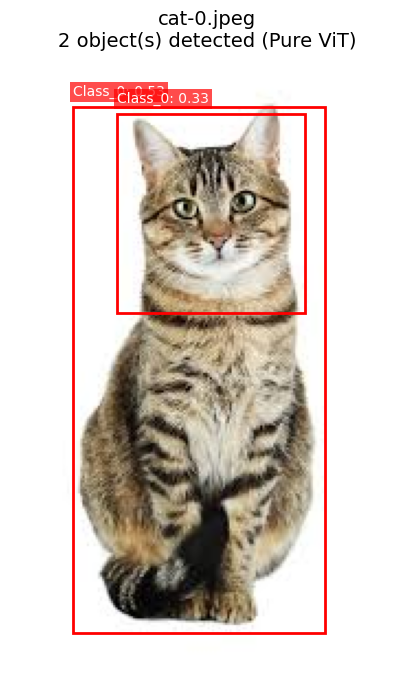


──────────────────────────────────────────────────────────────────────
📸 Test 2/20: cat-1.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (308, 164)
   🎯 Objects detected: 2
      • Class_0: 0.498
      • Class_0: 0.365
   📊 Showing 2 detections above threshold 0.3


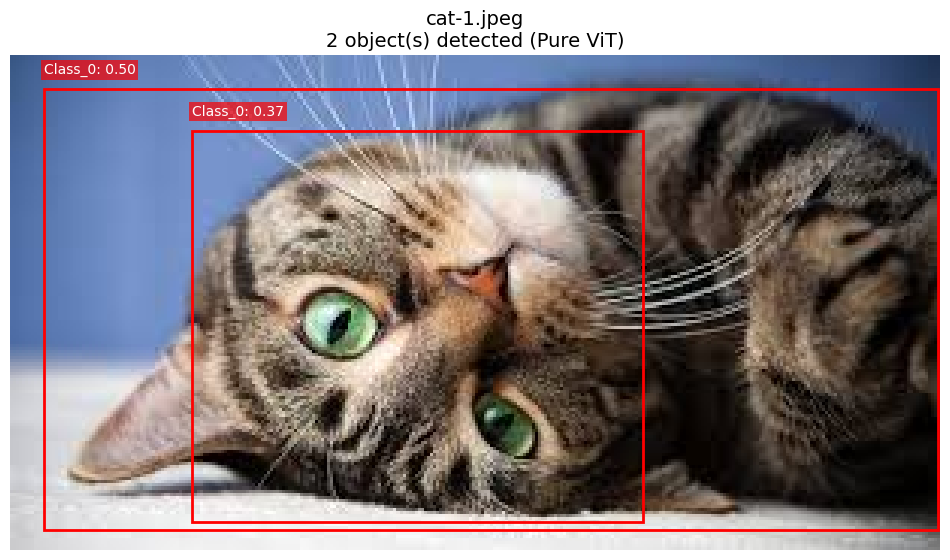


──────────────────────────────────────────────────────────────────────
📸 Test 3/20: cat-2.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 1
      • Class_0: 0.559
   📊 Showing 1 detections above threshold 0.3


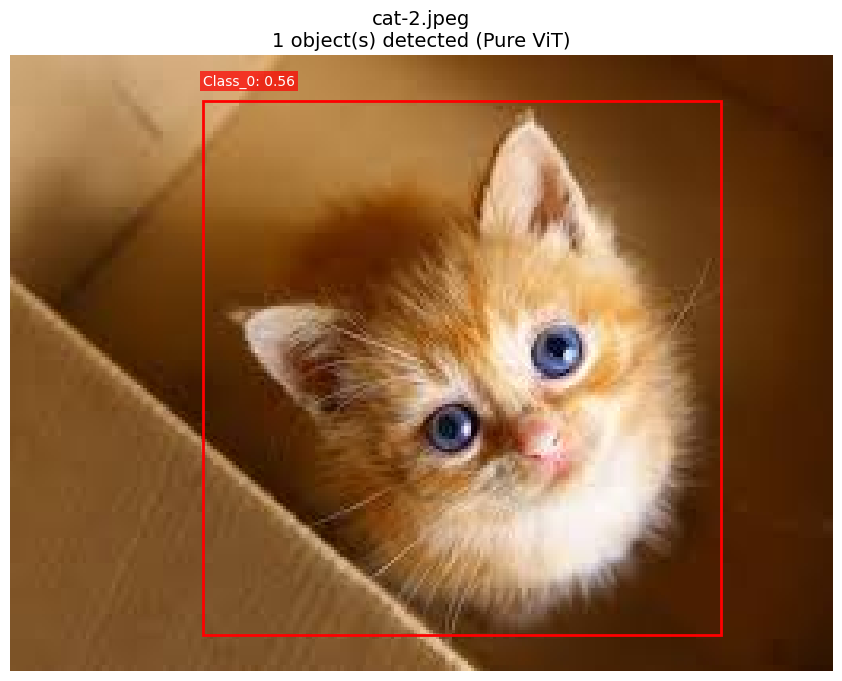


──────────────────────────────────────────────────────────────────────
📸 Test 4/20: cat-3.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (294, 172)
   🎯 Objects detected: 2
      • Class_0: 0.418
      • Class_0: 0.363
   📊 Showing 2 detections above threshold 0.3


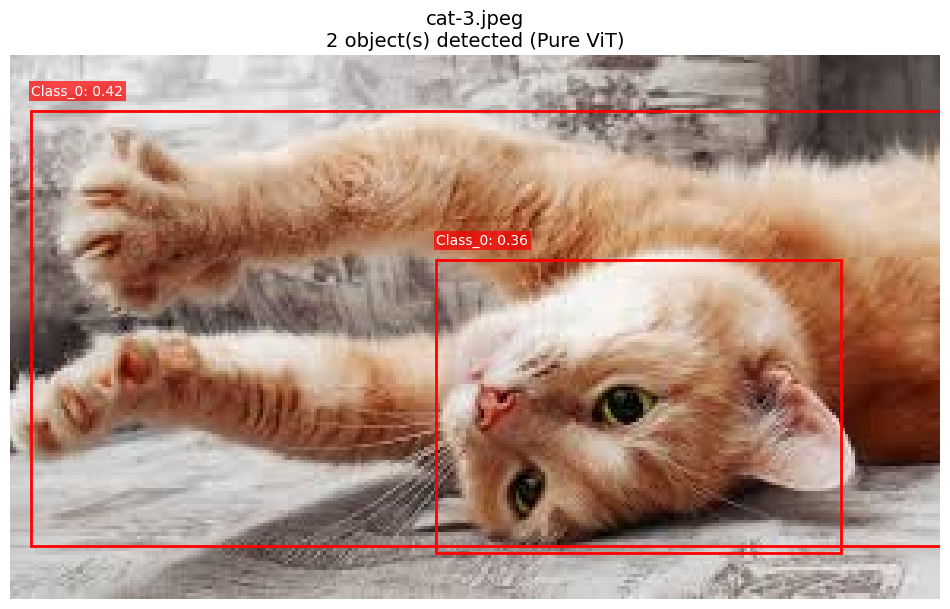


──────────────────────────────────────────────────────────────────────
📸 Test 5/20: cat-4.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (270, 187)
   🎯 Objects detected: 1
      • Class_0: 0.506
   📊 Showing 1 detections above threshold 0.3


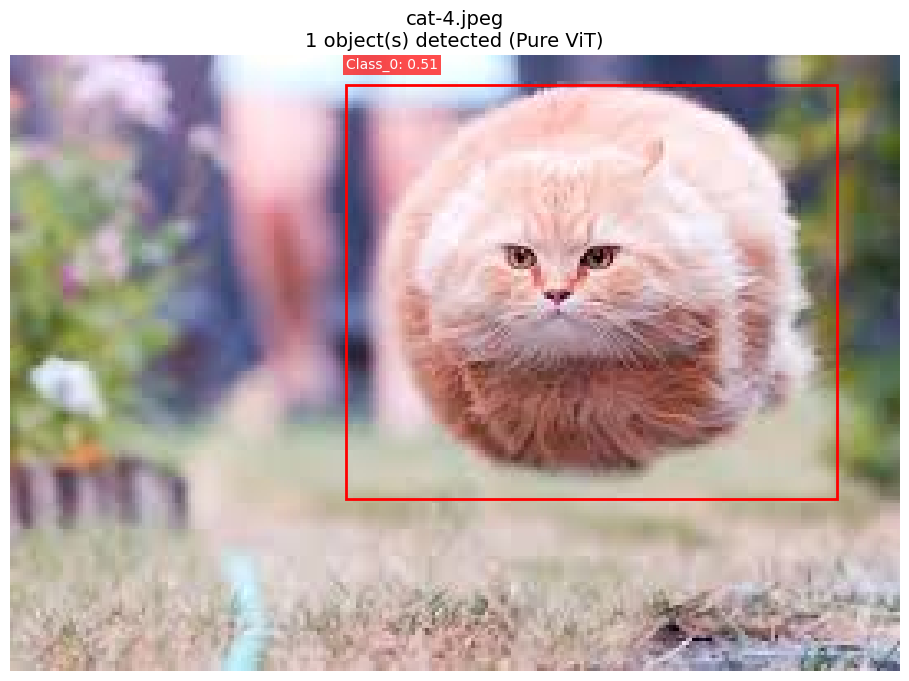


──────────────────────────────────────────────────────────────────────
📸 Test 6/20: cat-5.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (275, 183)
   🎯 Objects detected: 1
      • Class_0: 0.451
   📊 Showing 1 detections above threshold 0.3


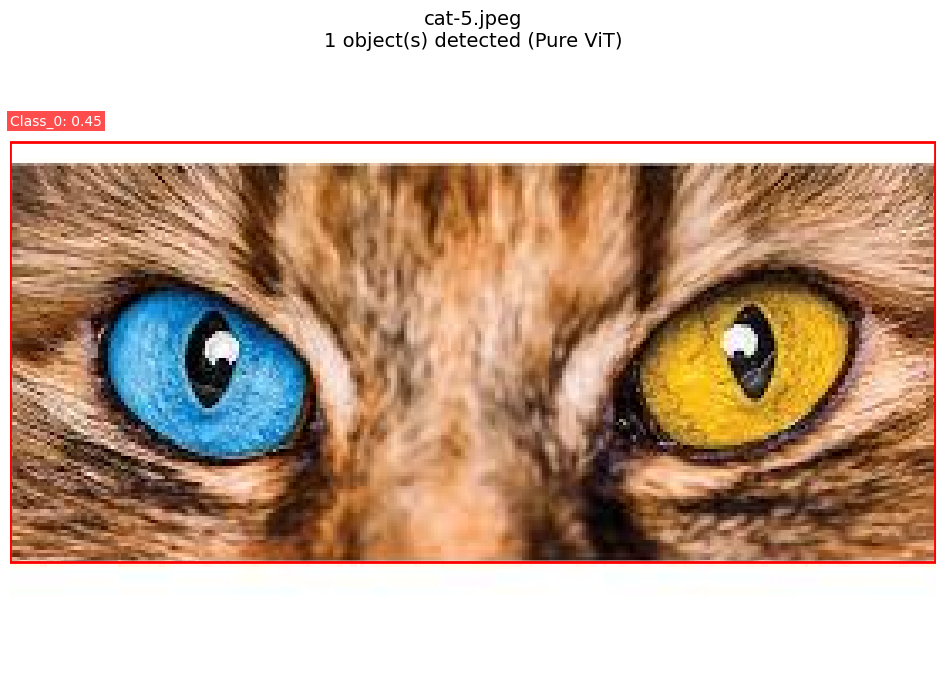


──────────────────────────────────────────────────────────────────────
📸 Test 7/20: cat-6.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (284, 178)
   🎯 Objects detected: 0
   ⚠️  No objects detected


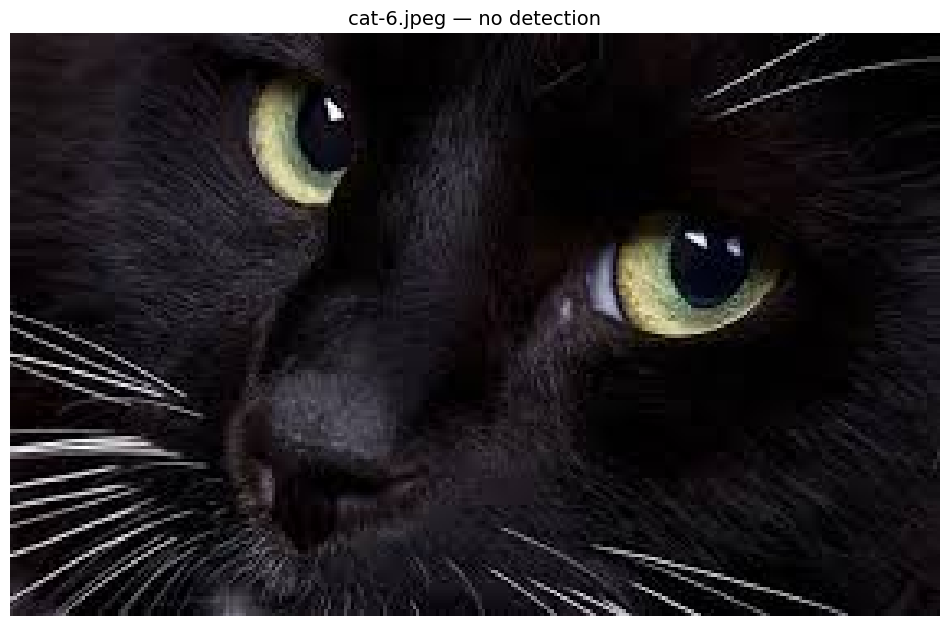


──────────────────────────────────────────────────────────────────────
📸 Test 8/20: cat-7.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (202, 250)
   🎯 Objects detected: 2
      • Class_0: 0.480
      • Class_0: 0.305
   📊 Showing 2 detections above threshold 0.3


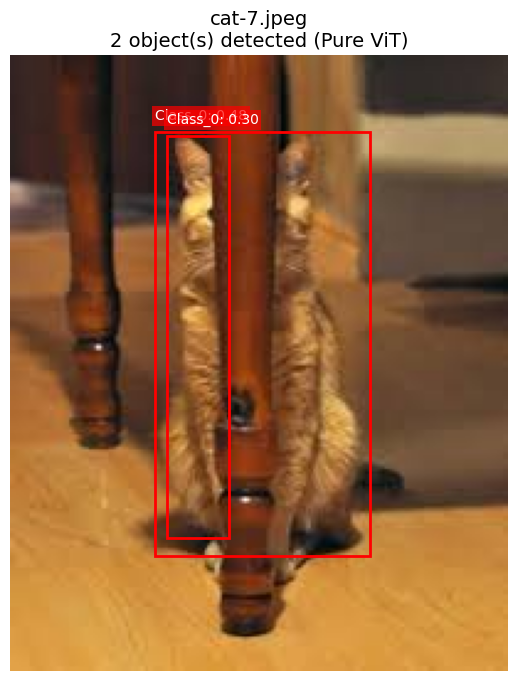


──────────────────────────────────────────────────────────────────────
📸 Test 9/20: cat-camouflaged-1.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (264, 191)
   🎯 Objects detected: 1
      • Class_0: 0.537
   📊 Showing 1 detections above threshold 0.3


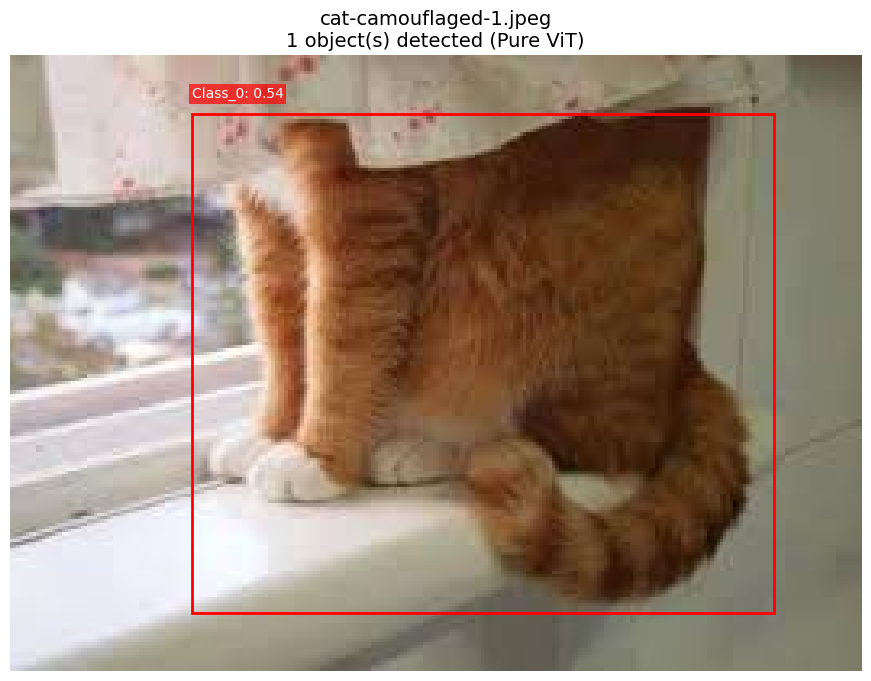


──────────────────────────────────────────────────────────────────────
📸 Test 10/20: cat-camouflaged-10.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (296, 170)
   🎯 Objects detected: 2
      • Class_0: 0.405
      • Class_0: 0.338
   📊 Showing 2 detections above threshold 0.3


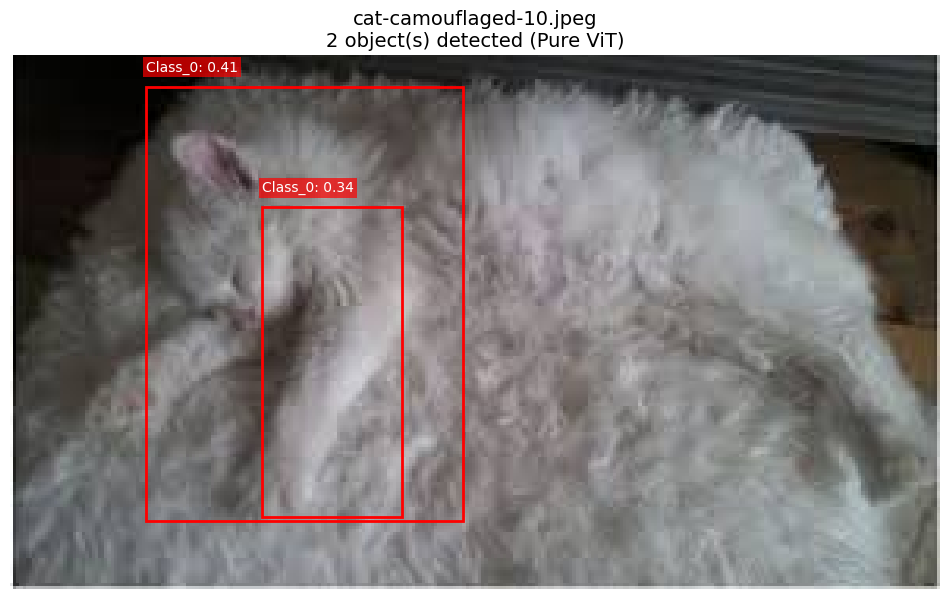


──────────────────────────────────────────────────────────────────────
📸 Test 11/20: cat-camouflaged-11.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (262, 192)
   🎯 Objects detected: 3
      • Class_0: 0.370
      • Class_0: 0.525
      • Class_0: 0.306
   📊 Showing 3 detections above threshold 0.3


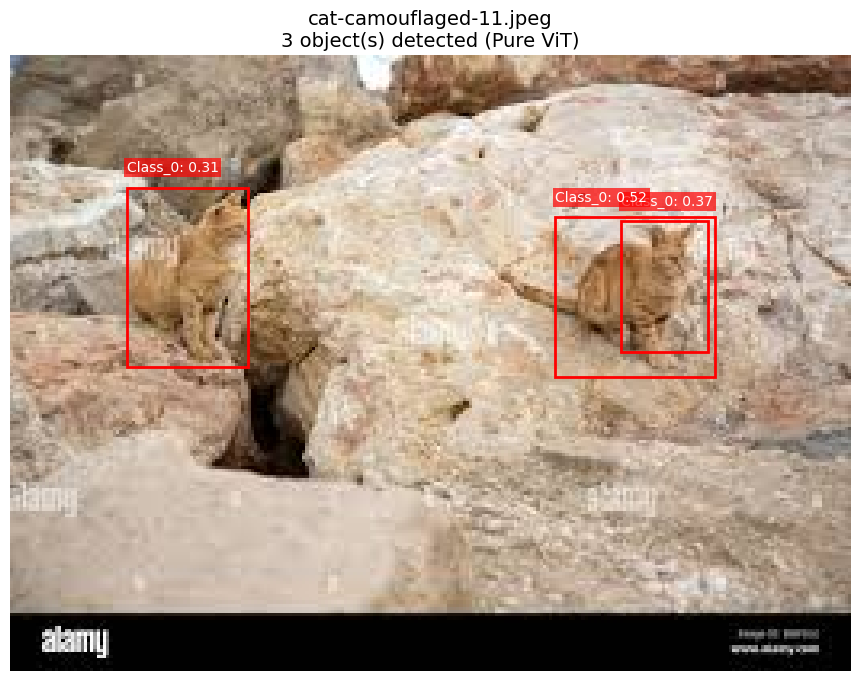


──────────────────────────────────────────────────────────────────────
📸 Test 12/20: cat-camouflaged-2.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (241, 209)
   🎯 Objects detected: 3
      • Class_0: 0.302
      • Class_0: 0.490
      • Class_0: 0.434
   📊 Showing 3 detections above threshold 0.3


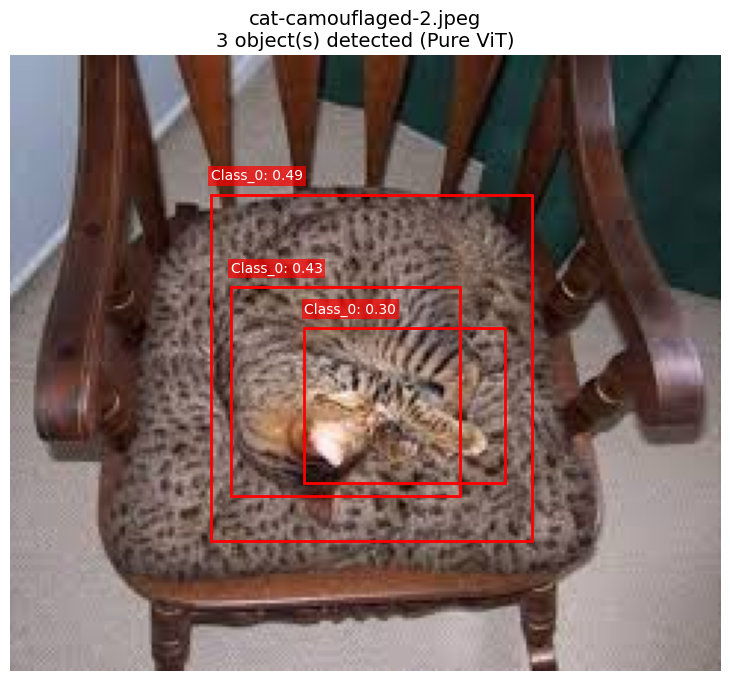


──────────────────────────────────────────────────────────────────────
📸 Test 13/20: cat-camouflaged-3.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (223, 226)
   🎯 Objects detected: 0
   ⚠️  No objects detected


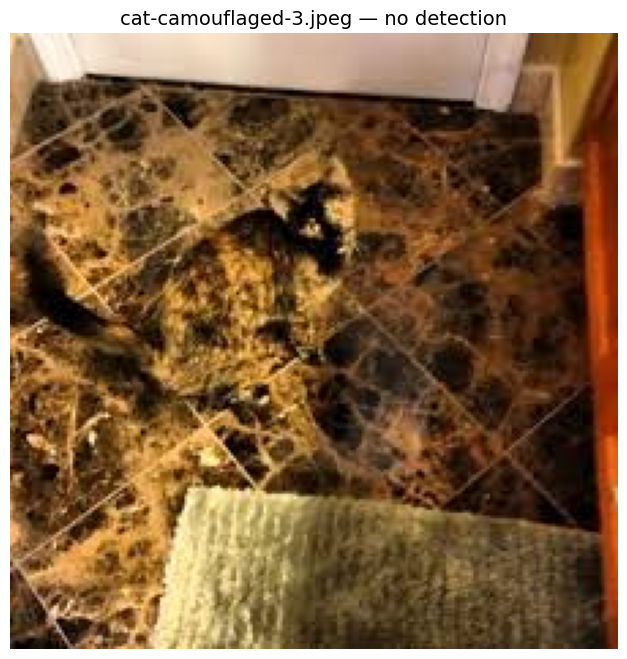


──────────────────────────────────────────────────────────────────────
📸 Test 14/20: cat-camouflaged-4.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 1
      • Class_0: 0.332
   📊 Showing 1 detections above threshold 0.3


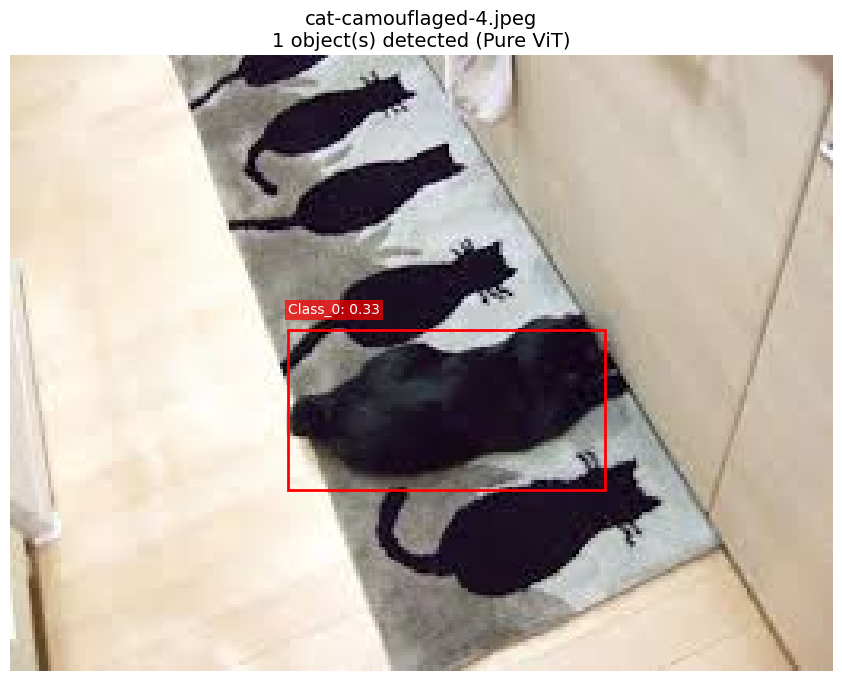


──────────────────────────────────────────────────────────────────────
📸 Test 15/20: cat-camouflaged-5.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (224, 225)
   🎯 Objects detected: 3
      • Class_0: 0.382
      • Class_0: 0.499
      • Class_0: 0.421
   📊 Showing 3 detections above threshold 0.3


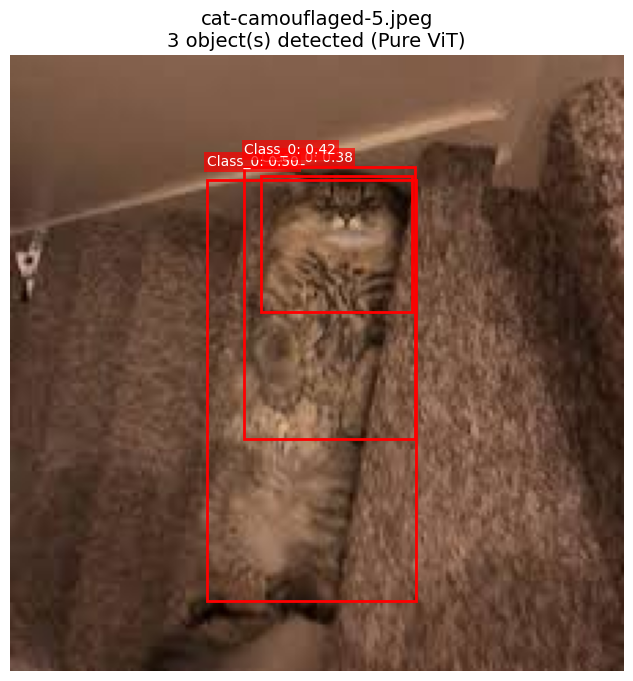


──────────────────────────────────────────────────────────────────────
📸 Test 16/20: cat-camouflaged-6.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (275, 183)
   🎯 Objects detected: 1
      • Class_0: 0.514
   📊 Showing 1 detections above threshold 0.3


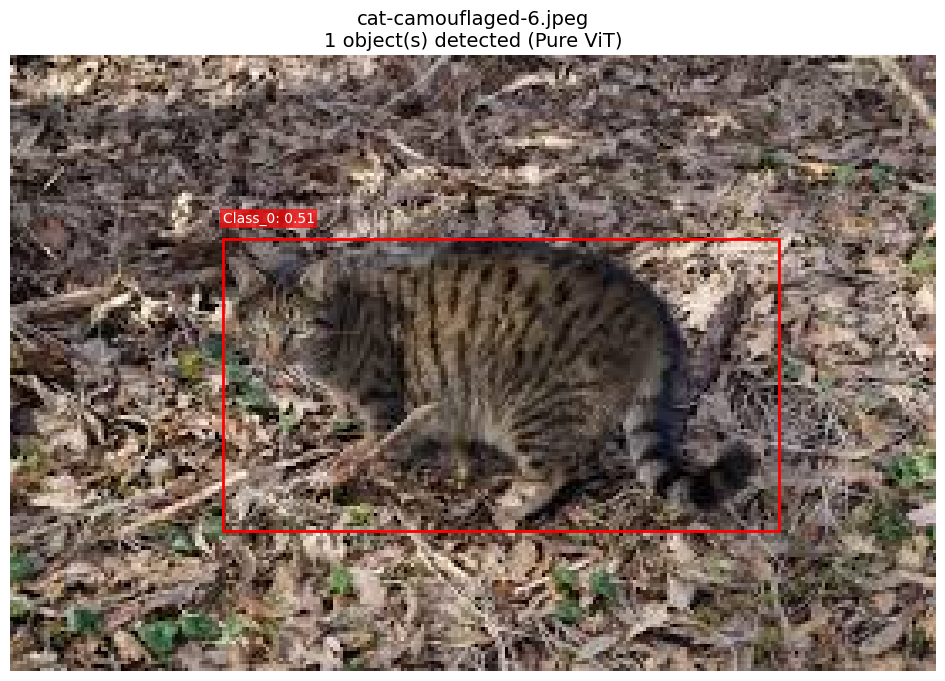


──────────────────────────────────────────────────────────────────────
📸 Test 17/20: cat-camouflaged-7.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 0
   ⚠️  No objects detected


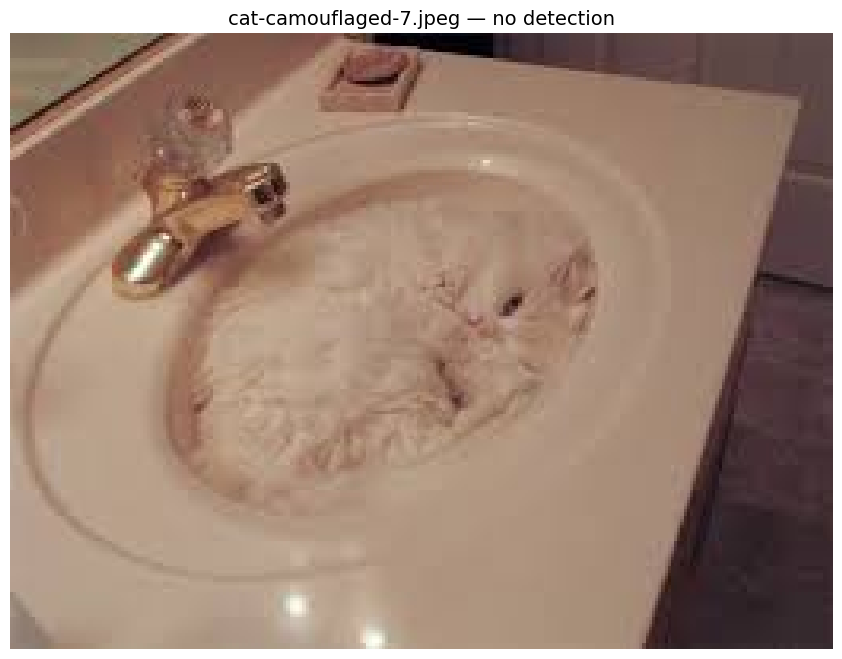


──────────────────────────────────────────────────────────────────────
📸 Test 18/20: cat-camouflaged-8.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (275, 183)
   🎯 Objects detected: 1
      • Class_0: 0.362
   📊 Showing 1 detections above threshold 0.3


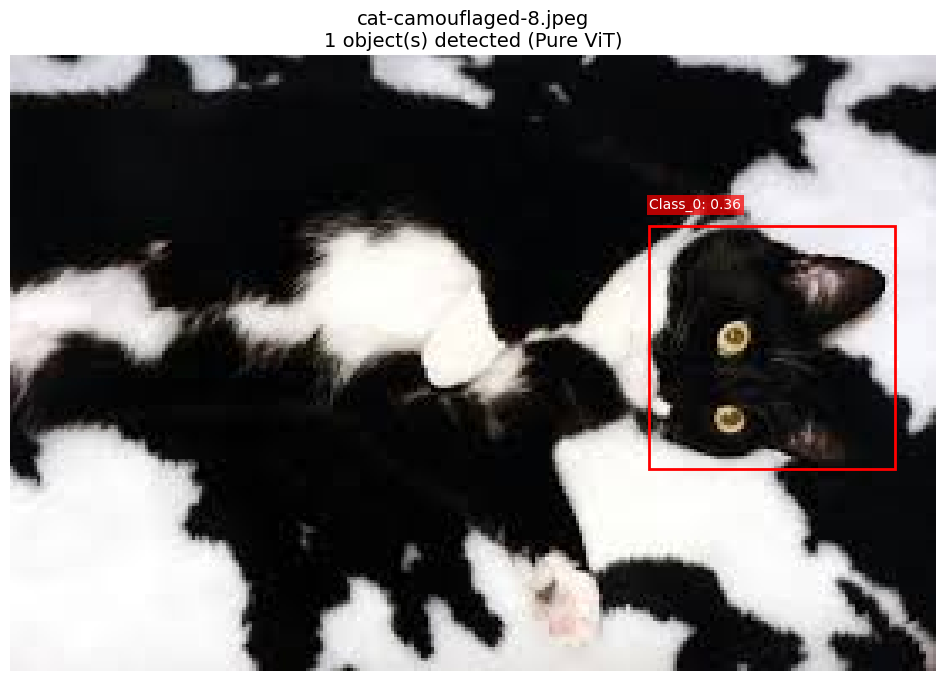


──────────────────────────────────────────────────────────────────────
📸 Test 19/20: cat-camouflaged-9.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (259, 194)
   🎯 Objects detected: 4
      • Class_0: 0.430
      • Class_0: 0.372
      • Class_0: 0.345
      • Class_0: 0.446
   📊 Showing 4 detections above threshold 0.3


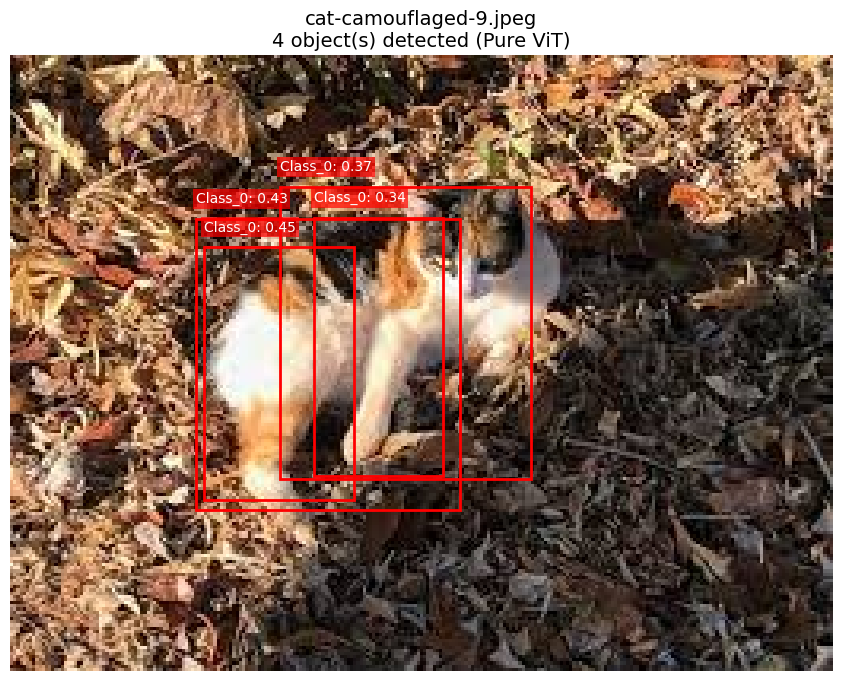


──────────────────────────────────────────────────────────────────────
📸 Test 20/20: owl.jpeg
──────────────────────────────────────────────────────────────────────
   Dimensions: (268, 188)
   🎯 Objects detected: 0
   ⚠️  No objects detected


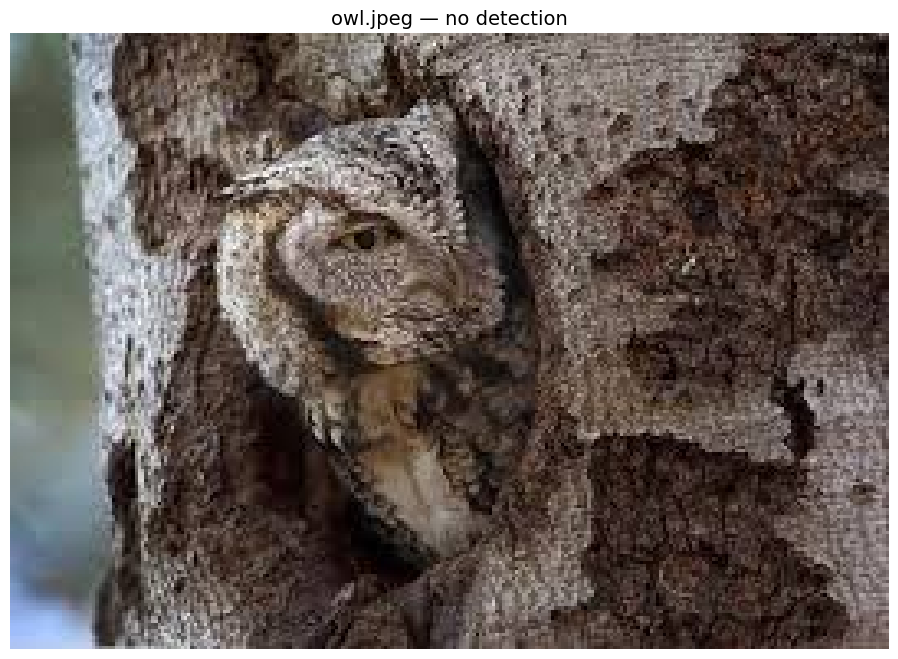


✅ TESTING COMPLETED!


In [ ]:
# ============================================================
# TEST: Run Inference with YOLOS
# ============================================================

test_images_path = Path(TEST_IMAGES_DIR)
image_files = sorted(
    list(test_images_path.glob('*.jpg')) +
    list(test_images_path.glob('*.png')) +
    list(test_images_path.glob('*.jpeg'))
)

if not image_files:
    print(f"❌ No images found in {TEST_IMAGES_DIR}")
else:
    print(f"\n🖼️  Found {len(image_files)} test images\n")

    for idx, img_path in enumerate(image_files, 1):
        print(f"\n{'─'*70}")
        print(f"📸 Test {idx}/{len(image_files)}: {img_path.name}")
        print(f"{'─'*70}")

        image = Image.open(img_path).convert("RGB")
        print(f"   Dimensions: {image.size}")

        res  = predict_image(image, model, processor, device,
                             conf_threshold=CONFIDENCE_THRESHOLD,
                             iou_threshold=IOU_THRESHOLD)

        num_detections = (res["scores"] >= CONFIDENCE_THRESHOLD).sum().item()
        print(f"   🎯 Objects detected: {num_detections}")

        if num_detections > 0:
            keep = res["scores"] >= CONFIDENCE_THRESHOLD
            for score, label in zip(res["scores"][keep], res["labels"][keep]):
                name = processor.id2label.get(label.item(), f"Class_{label.item()}")
                print(f"      • {name}: {score:.3f}")

            fig = visualize_predictions(image, res, processor, CONFIDENCE_THRESHOLD)
            plt.title(
                f"{img_path.name}\n{num_detections} object(s) detected (Pure ViT)",
                fontsize=14
            )
            plt.show()
        else:
            print("   ⚠️  No objects detected")
            plt.figure(figsize=(12, 8))
            plt.imshow(image)
            plt.title(f"{img_path.name} — no detection", fontsize=14)
            plt.axis('off')
            plt.show()

    print(f"\n{'='*70}")
    print("✅ TESTING COMPLETED!")
    print(f"{'='*70}")


## 🔍 YOLOS Architecture


In [ ]:
# ============================================================
# INSPECT YOLOS ARCHITECTURE
# ============================================================

print("🔷 YOLOS Architecture Inspection:\n")
print("📐 Model Structure:")
print(f"   Total parameters:     {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print("\n🔷 Vision Transformer Components:")
for name, module in model.named_children():
    print(f"   • {name}: {type(module).__name__}")

print("\n📊 Key Architecture Details:")
config = model.config
print(f"   • Hidden size:          {config.hidden_size}")
print(f"   • Number of att. heads: {config.num_attention_heads}")
print(f"   • Number of layers:     {config.num_hidden_layers}")
print(f"   • Patch size:           {config.patch_size}×{config.patch_size}")
print(f"   • Image size:           {config.image_size}")
print("\n✅ Vision Transformer - No CNN backbone!")


🔷 YOLOS Architecture Inspection:

📐 Model Structure:
   Total parameters:     30,650,118
   Trainable parameters: 30,650,118

🔷 Vision Transformer Components:
   • vit: YolosModel
   • class_labels_classifier: YolosMLPPredictionHead
   • bbox_predictor: YolosMLPPredictionHead

📊 Key Architecture Details:
   • Hidden size:          384
   • Number of att. heads: 6
   • Number of layers:     12
   • Patch size:           16×16
   • Image size:           [512, 864]

✅ Vision Transformer - No CNN backbone!
